In [1]:
#Installation and Setup
!pip install tensorflow scikit-learn xgboost numpy pandas matplotlib seaborn opencv-python shap tqdm Pillow joblib
!sudo apt-get install tree
!pip install scikit-optimize

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following NEW packages will be installed:
  tree
0 upgraded, 1 newly installed, 0 to remove and 38 not upgraded.
Need to get 47.9 kB of archives.
After this operation, 116 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/universe amd64 tree amd64 2.0.2-1 [47.9 kB]
Fetched 47.9 kB in 0s (353 kB/s)
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf/FrontEnd/Dialog.pm line 78, <> line 1.)
debconf: falling back to frontend: Readline
Selecting previously unselected package tree.
(Reading database ... 128663 files and directories currently installed.)
Preparing to unpack .../tree_2.0.2-1_amd64.deb ...
Unpacking tree (2.0.2-1) ...
Setting up tree (2.0.2-1) ...
Processing triggers for man-db (2.10.2-1) ...


In [2]:
import os
import sys
import math
import random
import time
import shutil
import zipfile
from pathlib import Path
import joblib
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler, label_binarize
from sklearn.utils.class_weight import compute_class_weight, compute_sample_weight
from sklearn.model_selection import RandomizedSearchCV, StratifiedKFold
from sklearn.metrics import (
    classification_report, confusion_matrix, accuracy_score, f1_score, make_scorer,
    roc_curve, auc, precision_recall_curve, matthews_corrcoef, cohen_kappa_score)
from scipy.stats import uniform, randint
import tensorflow as tf
from tensorflow.keras import layers, models, callbacks, regularizers, applications, mixed_precision
from tensorflow.keras.preprocessing.image import load_img, img_to_array, ImageDataGenerator
from tensorflow.keras.utils import image_dataset_from_directory
import cv2
import xgboost as xgb
from skopt import BayesSearchCV
from skopt.space import Real, Integer
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import ListedColormap
from tqdm import tqdm
import IPython.display as display
from PIL import Image

#GOOGLE COLAB SPECIFIC
try:
    from google.colab import drive
    IN_COLAB = True
except ImportError:
    IN_COLAB = False

2025-08-07 19:31:19.677052: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1754595079.874792      36 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1754595079.930511      36 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [3]:
#SET GLOBAL STYLES
plt.style.use('ggplot')
sns.set_style('whitegrid')
plt.rcParams.update({
    'font.size': 12,
    'figure.figsize': (10, 6),
    'axes.titlesize': 16,
    'axes.labelsize': 14,
    'xtick.labelsize': 12,
    'ytick.labelsize': 12
})

#VERSION CHECK
print(f"TensorFlow Version: {tf.__version__}")
print(f"NumPy Version: {np.__version__}")
print(f"XGBoost Version: {xgb.__version__}")

TensorFlow Version: 2.18.0
NumPy Version: 1.26.4
XGBoost Version: 2.0.3


In [4]:
# Set random seeds for reproducibility
SEED = 20
tf.keras.utils.set_random_seed(SEED)
np.random.seed(SEED)
random.seed(SEED)

In [5]:
# Update these paths according to your Google Drive structure
BASE_DIR = Path("/kaggle/working/")
ZIP_PATH = Path("/kaggle/input/myproject/myproject")
EXTRACT_DIR = Path("/kaggle/input/myproject/myproject")
OUTPUT_DIR = BASE_DIR / "split_and_augmented"
MODEL_DIR = BASE_DIR / "models"
FIGURE_DIR = BASE_DIR / "figures"

In [6]:
# Dataset parameters
CLASSES = ['Glaucoma', 'Myopia', 'Disc Edema', 'Healthy']
NUM_CLASSES = len(CLASSES)
IMG_SIZE = (224, 224)

In [7]:
# Data splitting
ORIGINALS_TO_PICK = 127
TRAIN_FRAC = 0.70
VAL_FRAC = 0.15
TEST_FRAC = 0.15
TARGET_TRAIN_PER_CLASS = 1000

In [8]:
# CNN parameters
CNN_EPOCHS_PHASE1 = 30
CNN_EPOCHS_PHASE2 = 20
CNN_LEARNING_RATE_PHASE1 = 5e-4
CNN_LEARNING_RATE_PHASE2 = 1e-5
CNN_PATIENCE_PHASE1 = 5
CNN_PATIENCE_PHASE2 = 3
CNN_DROPOUT_RATE_1 = 0.4
CNN_DROPOUT_RATE_2 = 0.5
CNN_L2_REG = 0.001
CNN_ATTENTION_RATIO = 16
TTA_AUGMENTATIONS = 5
GRAD_CAM_LAYER_NAME = 'conv5_block3_out'


# XGBoost parameters
XGB_N_ITER_RANDOM_SEARCH = 20
XGB_N_JOBS = -1
XGB_EARLY_STOPPING_ROUNDS = 20


# Ensemble parameters
ENSEMBLE_CNN_WEIGHT = 0.6
ENSEMBLE_XGB_WEIGHT = 0.4

In [9]:
# Create directories
MODEL_DIR.mkdir(parents=True, exist_ok=True)
FIGURE_DIR.mkdir(parents=True, exist_ok=True)
(FIGURE_DIR / 'grad_cam').mkdir(exist_ok=True)
(FIGURE_DIR / 'shap').mkdir(exist_ok=True)

In [10]:
# Data Preparation

def clean_and_setup_directories():
    if OUTPUT_DIR.exists():
        print(f"Removing old output directory: {OUTPUT_DIR}")
        shutil.rmtree(OUTPUT_DIR)

    for split in ['train', 'val', 'test']:
        for cls in CLASSES:
            (OUTPUT_DIR / split / cls).mkdir(parents=True, exist_ok=True)

def extract_zip_if_needed():
    if not EXTRACT_DIR.exists():
        print(f"Extracting ZIP to {EXTRACT_DIR}...")
        with zipfile.ZipFile(ZIP_PATH, 'r') as zip_ref:
            zip_ref.extractall(EXTRACT_DIR)

def split_originals_and_augment_training():
    print("\nProcessing classes for splitting and augmentation...")

    # Create a more efficient ImageDataGenerator
    datagen = tf.keras.preprocessing.image.ImageDataGenerator(
        rotation_range=30,
        width_shift_range=0.1,
        height_shift_range=0.1,
        zoom_range=0.15,
        brightness_range=(0.9, 1.1),
        horizontal_flip=True,
        fill_mode='reflect',
    )

    for cls in CLASSES:
        print(f"--- Class: {cls} ---")

        # Find the source folder for the class
        matching_folders = list(EXTRACT_DIR.rglob(f"*{cls}*"))
        if not matching_folders:
            print(f"!! Could not find folder for class '{cls}'. Skipping. !!")
            continue
        src_folder = matching_folders[0]

        # Get all image files
        image_extensions = ['*.jpg', '*.jpeg', '*.png', '*.bmp']
        all_image_files = []
        for ext in image_extensions:
            all_image_files.extend(src_folder.glob(ext))

        if len(all_image_files) < ORIGINALS_TO_PICK:
            raise ValueError(f"Not enough images for class '{cls}': Found {len(all_image_files)}, need {ORIGINALS_TO_PICK}")

        random.Random(SEED).shuffle(all_image_files)
        selected_originals = all_image_files[:ORIGINALS_TO_PICK]

        #Splitting Logic
        num_train = math.floor(ORIGINALS_TO_PICK * TRAIN_FRAC)
        num_val = math.floor(ORIGINALS_TO_PICK * VAL_FRAC)

        train_files = selected_originals[:num_train]
        val_files = selected_originals[num_train : num_train + num_val]
        test_files = selected_originals[num_train + num_val:]

        print(f"Splitting {ORIGINALS_TO_PICK} originals: {len(train_files)} train, {len(val_files)} val, {len(test_files)} test")

        #Copy original files
        print("Copying original files...")
        for file_list, split_name in [(train_files, 'train'), (val_files, 'val'), (test_files, 'test')]:
            for img_path in file_list:
                dest_path = OUTPUT_DIR / split_name / cls / img_path.name
                dest_path.parent.mkdir(parents=True, exist_ok=True)
                shutil.copy(img_path, dest_path)

        #Augment the TRAINING set
        train_class_dir = OUTPUT_DIR / 'train' / cls
        num_originals_in_train = len(list(train_class_dir.glob('*.*')))
        required_augments = TARGET_TRAIN_PER_CLASS - num_originals_in_train

        if required_augments <= 0:
            print(f"Sufficient training images exist. No augmentation needed for {cls}.")
        else:
            print(f"Augmenting {required_augments} images for the '{cls}' training set...")

            # Preload all training images to avoid repeated file I/O
            images = []
            for img_path in train_files:
                try:
                    img = load_img(img_path, target_size=IMG_SIZE)
                    x = img_to_array(img)
                    images.append(x)
                except Exception as e:
                    print(f"Error loading {img_path}: {e}")

            if not images:
                print(f"No valid images found for augmentation in {cls}")
                continue

            images = np.array(images)

            # Create a single generator for all images
            batch_size = min(32, len(images))  # Use batch processing
            generator = datagen.flow(
                images,
                batch_size=batch_size,
                save_to_dir=train_class_dir,
                save_prefix='aug',
                save_format='jpeg',
                seed=SEED
            )

            # Generate required augmentations
            batches_needed = (required_augments + batch_size - 1) // batch_size
            for i in range(batches_needed):
                try:
                    # Use next() instead of .next()
                    next(generator)
                except Exception as e:
                    print(f"Error during augmentation batch {i+1}: {e}")

            print(f"Generated {batches_needed * batch_size} augmentations for {cls}")

        print(f"Class '{cls}' complete. Final training images: {len(list(train_class_dir.glob('*.*')))})")

    print("\n--- Dataset Creation Complete ---")
    print(f"Final dataset is ready in: {OUTPUT_DIR}")


def load_datasets(batch_size=32, shuffle_train=True):
    train_ds = tf.keras.preprocessing.image_dataset_from_directory(
        OUTPUT_DIR / 'train',
        image_size=IMG_SIZE,
        batch_size=batch_size,
        shuffle=shuffle_train,
        seed=SEED
    )

    val_ds = tf.keras.preprocessing.image_dataset_from_directory(
        OUTPUT_DIR / 'val',
        image_size=IMG_SIZE,
        batch_size=batch_size,
        shuffle=False
    )

    test_ds = tf.keras.preprocessing.image_dataset_from_directory(
        OUTPUT_DIR / 'test',
        image_size=IMG_SIZE,
        batch_size=batch_size,
        shuffle=False
    )

    #Normalization
    normalization_layer = tf.keras.layers.Rescaling(1./255)
    train_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
    val_ds = val_ds.map(lambda x, y: (normalization_layer(x), y))
    test_ds = test_ds.map(lambda x, y: (normalization_layer(x), y))


    # Optimize performance
    train_ds = train_ds.prefetch(tf.data.AUTOTUNE)
    val_ds = val_ds.prefetch(tf.data.AUTOTUNE)
    test_ds = test_ds.prefetch(tf.data.AUTOTUNE)

    return train_ds, val_ds, test_ds

def prepare_all_data():
    clean_and_setup_directories()
    extract_zip_if_needed()
    split_originals_and_augment_training()
    return load_datasets()

In [11]:
#CNN Model

def weighted_sparse_categorical_focal_loss(gamma=2.0, alpha=0.25, class_weights=None, label_smoothing=0.1):
    def loss_fn(y_true, y_pred):
        y_true = tf.cast(y_true, tf.int32)
        num_classes = y_pred.shape[-1]
        y_true_one_hot = tf.one_hot(y_true, num_classes)
        y_true_smooth = y_true_one_hot * (1.0 - label_smoothing) + (label_smoothing / tf.cast(num_classes, tf.float32))

        epsilon = tf.keras.backend.epsilon()
        y_pred = tf.clip_by_value(y_pred, epsilon, 1.0 - epsilon)

        p_t = tf.reduce_sum(y_true_smooth * y_pred, axis=-1)
        focal_weight = alpha * tf.pow(1.0 - p_t, gamma)

        if class_weights is not None:
            weight_vector = tf.constant([class_weights[i] for i in range(num_classes)], dtype=tf.float32)
            weights_for_true_labels = tf.gather(weight_vector, y_true)
            focal_weight = focal_weight * weights_for_true_labels

        loss = -focal_weight * tf.math.log(p_t)
        return tf.reduce_mean(loss)
    return loss_fn

def simple_channel_attention(input_tensor, ratio=16):
    channels = input_tensor.shape[-1]
    squeeze = tf.keras.layers.GlobalAveragePooling2D()(input_tensor)
    excitation = tf.keras.layers.Dense(channels // ratio, activation='relu')(squeeze)
    excitation = tf.keras.layers.Dense(channels, activation='sigmoid')(excitation)
    excitation = tf.keras.layers.Reshape((1, 1, channels))(excitation)
    scale = tf.keras.layers.Multiply()([input_tensor, excitation])
    return scale

def build_cnn_model():
    base = tf.keras.applications.ResNet50V2(
        input_shape=(IMG_SIZE[0], IMG_SIZE[1], 3),
        include_top=False,
        weights='imagenet'
    )
    x = base.output
    x = simple_channel_attention(x)
    avg_pool = tf.keras.layers.GlobalAveragePooling2D()(x)
    max_pool = tf.keras.layers.GlobalMaxPooling2D()(x)
    concat_pool = tf.keras.layers.Concatenate()([avg_pool, max_pool])

    x = tf.keras.layers.Dense(512, activation='relu',
                             kernel_regularizer=tf.keras.regularizers.l2(CNN_L2_REG))(concat_pool)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Dropout(CNN_DROPOUT_RATE_1)(x)

    x = tf.keras.layers.Dense(256, activation='relu',
                             kernel_regularizer=tf.keras.regularizers.l2(CNN_L2_REG))(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Dropout(CNN_DROPOUT_RATE_2)(x)

    outputs = tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')(x)
    model = tf.keras.Model(inputs=base.input, outputs=outputs)

    for layer in base.layers[:-50]:
        layer.trainable = False
    for layer in base.layers[-50:]:
        layer.trainable = True

    return model



def train_cnn_model(train_ds, val_ds):
    print("\n--- Initializing OPTIMIZED CNN Training ---")

    # Enable mixed precision for faster training
    policy = mixed_precision.Policy('mixed_float16')
    mixed_precision.set_global_policy(policy)

    model = build_cnn_model()
    model.summary()

    # Use more efficient class weight calculation
    class_counts = np.zeros(NUM_CLASSES)
    for _, labels in train_ds.unbatch():
        class_counts[labels.numpy()] += 1
    total_samples = np.sum(class_counts)
    class_weights = total_samples / (NUM_CLASSES * class_counts)
    class_weights_dict = {i: weight for i, weight in enumerate(class_weights)}

    print("Computed Class weights:", class_weights_dict)

    # Create a checkpoint callback to save progress periodically
    checkpoint_path = MODEL_DIR / 'cnn_checkpoint.weights.h5'
    checkpoint_callback = callbacks.ModelCheckpoint(
        filepath=checkpoint_path,
        save_weights_only=True,
        save_best_only=False,
        save_freq='epoch',  # Save after every epoch
        verbose=1
    )

    # Reduce batch size for GPU memory efficiency
    optimized_train_ds = train_ds.unbatch().batch(16).cache().prefetch(tf.data.AUTOTUNE)
    optimized_val_ds = val_ds.cache().prefetch(tf.data.AUTOTUNE)

    # Phase 1: Initial Training
    print("\n--- CNN Training Phase 1 ---")
    model.compile(
        optimizer=tf.keras.optimizers.AdamW(
            learning_rate=CNN_LEARNING_RATE_PHASE1,
            weight_decay=1e-4,
            clipnorm=1.0
        ),
        loss=weighted_sparse_categorical_focal_loss(
            gamma=2.0, alpha=0.25,
            class_weights=class_weights_dict,
            label_smoothing=0.1
        ),
        metrics=['accuracy']
    )

    # Train with smaller steps per epoch to prevent disconnects
    history1 = model.fit(
        optimized_train_ds,
        epochs=CNN_EPOCHS_PHASE1,
        steps_per_epoch = min(100, tf.data.experimental.cardinality(train_ds).numpy()),
        validation_data=optimized_val_ds,
        callbacks=[
            checkpoint_callback,
            callbacks.EarlyStopping(
                patience=CNN_PATIENCE_PHASE1,
                monitor='val_loss',
                restore_best_weights=True
            ),
            callbacks.ReduceLROnPlateau(
                monitor='val_loss',
                factor=0.5,
                patience=3,
                min_lr=1e-7
            )
        ],
        class_weight=class_weights_dict
    )

    # Phase 2: Fine-tuning
    print("\n--- CNN Training Phase 2 ---")
    for layer in model.layers:
        if hasattr(layer, 'trainable'):
            layer.trainable = True

    model.compile(
        optimizer=tf.keras.optimizers.AdamW(
            learning_rate=CNN_LEARNING_RATE_PHASE2,
            weight_decay=1e-5,
            clipnorm=1.0
        ),
        loss=weighted_sparse_categorical_focal_loss(
            gamma=2.0, alpha=0.25,
            class_weights=class_weights_dict,
            label_smoothing=0.1
        ),
        metrics=['accuracy']
    )

    # Train with periodic saving
    history2 = model.fit(
        optimized_train_ds,
        initial_epoch=history1.epoch[-1] + 1,
        epochs=CNN_EPOCHS_PHASE1 + CNN_EPOCHS_PHASE2,
        steps_per_epoch = min(100, tf.data.experimental.cardinality(train_ds).numpy()),
        validation_data=optimized_val_ds,
        callbacks=[
            checkpoint_callback,
            callbacks.EarlyStopping(
                patience=CNN_PATIENCE_PHASE2,
                monitor='val_loss',
                restore_best_weights=True
            ),
            callbacks.ReduceLROnPlateau(
                monitor='val_loss',
                factor=0.5,
                patience=2,
                min_lr=1e-8
            )
        ],
        class_weight=class_weights_dict
    )

    # Save final model
    model.save(MODEL_DIR / 'cnn_model.h5')

    # Combine histories
    combined_history = {k: history1.history[k] + history2.history[k] for k in history1.history}
    return model, combined_history

In [12]:
# XGBoost Model

def extract_cnn_features(cnn_model, dataset, layer_name='concatenate'):
    print(f"\n--- Extracting features from layer: '{layer_name}' ---")

    # Build feature extractor
    try:
        feature_extractor = tf.keras.Model(
            inputs=cnn_model.input,
            outputs=cnn_model.get_layer(layer_name).output
        )
    except:
        feature_extractor = tf.keras.Model(
            inputs=cnn_model.input,
            outputs=cnn_model.layers[-2].output
        )

    # Extract features in batches
    features, labels = [], []
    for images, lbls in tqdm(dataset, desc="Extracting features"):
        batch_feats = feature_extractor(images, training=False).numpy()
        features.append(batch_feats)
        labels.append(lbls.numpy())

    return np.vstack(features), np.concatenate(labels)



def train_xgboost_model(X_train, y_train, X_val, y_val):
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_val_scaled = scaler.transform(X_val)
    joblib.dump(scaler, MODEL_DIR / 'xgboost_scaler.pkl')



    search_spaces = {
    'learning_rate': Real(0.01, 0.3, prior='log-uniform'),
    'max_depth': Integer(3, 12),
    'n_estimators': Integer(300, 2000),
    'subsample': Real(0.5, 1.0),
    'colsample_bytree': Real(0.5, 1.0),
    'gamma': Real(0, 1),
    'reg_alpha': Real(0, 1),
    'reg_lambda': Real(0.5, 3),
    'min_child_weight': Integer(1, 10),
    }

    # Stratified K-Fold with more splits for better validation
    cv_strategy = StratifiedKFold(n_splits=3, shuffle=True, random_state=SEED)


    # Bayesian optimization
    bayes_search = BayesSearchCV(
        estimator=xgb.XGBClassifier(
            objective='multi:softprob',
            num_class=NUM_CLASSES,
            tree_method='hist',
            n_jobs=-1,
            random_state=SEED,
            use_label_encoder=False,
            eval_metric='mlogloss'),
        search_spaces=search_spaces,
        n_iter=10,
        cv=cv_strategy,
        n_jobs=2,
        verbose=2,
        random_state=SEED,
        scoring='f1_macro'
        )


    # Fit with sample weights
    bayes_search.fit(X_train_scaled, y_train)


    # Get best parameters
    best_bayes_params = bayes_search.best_params_
    print(f"\nBest parameters found: {best_bayes_params}")


    print("\nStage 2: Training final model with best parameters...")

    # Initialize final model with best parameters
    final_model = xgb.XGBClassifier(
        **best_bayes_params,
        objective='multi:softprob',
        num_class=4,
        tree_method='hist',
        n_jobs=-1,
        random_state=42,
        use_label_encoder=False,
        eval_metric=['mlogloss', 'merror']
        )

    # Train with evaluation
    final_model.fit(
        X_train_scaled, y_train,
        eval_set=[(X_train_scaled, y_train), (X_val_scaled, y_val)],
        verbose=100
        )

    # Save the trained model using joblib
    joblib.dump(final_model, MODEL_DIR / 'xgboost_model.pkl')

    return final_model, bayes_search.best_params_, scaler

# Check if features are available before calling train_xgboost_model
try:
    train_features
    train_labels
    val_features
    val_labels
except NameError:
    print("Please run the cell that extracts CNN features (cell ID: 5gGjw0FtOI6c) before running this cell.")

Please run the cell that extracts CNN features (cell ID: 5gGjw0FtOI6c) before running this cell.


In [31]:
#Ensemble System
class CNNXGBoostEnsembleClassifier:
    def __init__(self, cnn_model, xgb_model, xgb_scaler, cnn_weight=0.6, xgb_weight=0.4):
        self.cnn_model = cnn_model
        self.xgb_model = xgb_model
        self.xgb_scaler = xgb_scaler
        self.cnn_weight = cnn_weight
        self.xgb_weight = xgb_weight

        self.feature_extractor = tf.keras.Model(
            inputs=cnn_model.input,
            outputs=cnn_model.get_layer('concatenate').output
        )

    def predict_proba(self, dataset):
        cnn_probs = []
        xgb_probs = []
        true_labels = []

        for images, labels in dataset:
            # CNN predictions
            cnn_pred = self.cnn_model.predict(images)
            cnn_probs.append(cnn_pred)

            # XGBoost predictions
            features = self.feature_extractor(images).numpy()
            features_scaled = self.xgb_scaler.transform(features)
            xgb_pred = self.xgb_model.predict_proba(features_scaled)
            xgb_probs.append(xgb_pred)

            true_labels.append(labels.numpy())

        cnn_probs = np.vstack(cnn_probs)
        xgb_probs = np.vstack(xgb_probs)
        ensemble_probs = (self.cnn_weight * cnn_probs) + (self.xgb_weight * xgb_probs)

        return ensemble_probs, np.concatenate(true_labels)

In [14]:
# EVALUATION UTILITIES
def plot_training_history(history, title_suffix="", save_path=None):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))
    ax1.plot(history['accuracy'], label='Train Accuracy')
    ax1.plot(history['val_accuracy'], label='Val Accuracy')
    ax1.set_title(f'Model Accuracy {title_suffix}')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Accuracy')
    ax1.legend()
    ax1.grid(True)

    ax2.plot(history['loss'], label='Train Loss')
    ax2.plot(history['val_loss'], label='Val Loss')
    ax2.set_title(f'Model Loss {title_suffix}')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Loss')
    ax2.legend()
    ax2.grid(True)

    plt.tight_layout()
    if save_path:
        plt.savefig(save_path)
    plt.show()


def plot_confusion_matrix(y_true, y_pred, class_names, title_suffix="", save_path=None):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 7))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names,
                yticklabels=class_names)
    plt.title(f'Confusion Matrix {title_suffix}')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')

    for i in range(len(class_names)):
        for j in range(len(class_names)):
            total_true = cm[i].sum()
            if total_true > 0:
                percentage = cm[i, j] / total_true * 100
                plt.text(j + 0.5, i + 0.7, f'{percentage:.1f}%',
                         ha='center', va='center', fontsize=8, color='red')

    plt.tight_layout()
    if save_path:
        plt.savefig(save_path)
    plt.show()

def calculate_and_print_metrics(y_true, y_pred, y_pred_proba, class_names, model_name):
    print(f"\n{'-'*60}")
    print(f"CLASSIFICATION REPORT - {model_name.upper()}")
    print(f"{'-'*60}")
    print(classification_report(y_true, y_pred, target_names=class_names, digits=4))

    accuracy = accuracy_score(y_true, y_pred)
    mcc = matthews_corrcoef(y_true, y_pred)
    kappa = cohen_kappa_score(y_true, y_pred)

    print(f"\nOverall Accuracy: {accuracy:.4f}")
    print(f"Matthews Correlation Coefficient (MCC): {mcc:.4f}")
    print(f"Cohen's Kappa Score: {kappa:.4f}")

    return classification_report(y_true, y_pred, target_names=class_names, output_dict=True)

def plot_roc_curves(y_true, y_pred_proba, class_names, title_suffix="", save_path=None):
    y_true_bin = label_binarize(y_true, classes=range(len(class_names)))

    plt.figure(figsize=(9, 8))
    for i in range(len(class_names)):
        fpr, tpr, _ = roc_curve(y_true_bin[:, i], y_pred_proba[:, i])
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, label=f'{class_names[i]} (AUC = {roc_auc:.3f})')

    plt.plot([0, 1], [0, 1], 'k--', label='Random (AUC = 0.50)')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curves {title_suffix}')
    plt.legend(loc="lower right")
    plt.grid(True, alpha=0.3)
    if save_path:
        plt.savefig(save_path)
    plt.show()

def plot_per_class_metrics(report, title_suffix="", save_path=None):
    metrics = ['precision', 'recall', 'f1-score']
    classes = list(report.keys())[:-3]  # Exclude avg/macro

    fig, axes = plt.subplots(1, 3, figsize=(18, 5))
    for i, metric in enumerate(metrics):
        values = [report[cls][metric] for cls in classes]
        axes[i].bar(classes, values, color='skyblue')
        axes[i].set_title(f'{metric.capitalize()} {title_suffix}')
        axes[i].set_ylim(0, 1.1)

        for j, v in enumerate(values):
            axes[i].text(j, v + 0.02, f'{v:.3f}', ha='center', va='bottom')

    plt.tight_layout()
    if save_path:
        plt.savefig(save_path)
    plt.show()

In [15]:
#MODEL EVALUATION FUNCTIONS
def evaluate_cnn(model, test_ds, history, model_name="CNN"):
    print(f"\n--- Evaluating {model_name} Model ---")

    # Collect predictions and labels
    y_true = []
    y_pred_proba = []

    for images, labels in test_ds:
        y_true.extend(labels.numpy())
        y_pred_proba.extend(model.predict(images, verbose=0))

    y_true = np.array(y_true)
    y_pred_proba = np.array(y_pred_proba)
    y_pred = np.argmax(y_pred_proba, axis=1)

    # Plot training history
    plot_training_history(
        history,
        title_suffix=model_name,
        save_path=FIGURE_DIR / f'training_history_{model_name.lower()}.png'
    )

    # Calculate metrics
    report = calculate_and_print_metrics(
        y_true, y_pred, y_pred_proba, CLASSES, model_name
    )

    # Generate plots
    plot_confusion_matrix(
        y_true, y_pred, CLASSES,
        title_suffix=model_name,
        save_path=FIGURE_DIR / f'confusion_matrix_{model_name.lower()}.png'
    )

    plot_roc_curves(
        y_true, y_pred_proba, CLASSES,
        title_suffix=model_name,
        save_path=FIGURE_DIR / f'roc_curves_{model_name.lower()}.png'
    )

    plot_per_class_metrics(
        report,
        title_suffix=model_name,
        save_path=FIGURE_DIR / f'per_class_metrics_{model_name.lower()}.png'
    )

    return y_pred_proba, y_true

def evaluate_xgboost(model, scaler, X_test, y_test, model_name="XGBoost"):
    print(f"\n--- Evaluating {model_name} Model ---")

    # Scale features and predict
    X_test_scaled = scaler.transform(X_test)
    y_pred_proba = model.predict_proba(X_test_scaled)
    y_pred = np.argmax(y_pred_proba, axis=1)

    # Calculate metrics
    report = calculate_and_print_metrics(
        y_test, y_pred, y_pred_proba, CLASSES, model_name
    )

    # Generate plots
    plot_confusion_matrix(
        y_test, y_pred, CLASSES,
        title_suffix=model_name,
        save_path=FIGURE_DIR / f'confusion_matrix_{model_name.lower()}.png'
    )

    plot_roc_curves(
        y_test, y_pred_proba, CLASSES,
        title_suffix=model_name,
        save_path=FIGURE_DIR / f'roc_curves_{model_name.lower()}.png'
    )

    plot_per_class_metrics(
        report,
        title_suffix=model_name,
        save_path=FIGURE_DIR / f'per_class_metrics_{model_name.lower()}.png'
    )

    # Feature importance
    plt.figure(figsize=(12, 8))
    xgb.plot_importance(model, max_num_features=20)
    plt.title(f'Feature Importance - {model_name}')
    plt.savefig(FIGURE_DIR / f'feature_importance_{model_name.lower()}.png')
    plt.show()

    return y_pred_proba, y_test

def evaluate_ensemble(ensemble, test_ds, model_name="Ensemble"):
    print(f"\n--- Evaluating {model_name} Model ---")

    # Get predictions from ensemble
    y_pred_proba, y_true = ensemble.predict_proba(test_ds)
    y_pred = np.argmax(y_pred_proba, axis=1)

    # Calculate metrics
    report = calculate_and_print_metrics(
        y_true, y_pred, y_pred_proba, CLASSES, model_name
    )

    # Generate plots
    plot_confusion_matrix(
        y_true, y_pred, CLASSES,
        title_suffix=model_name,
        save_path=FIGURE_DIR / f'confusion_matrix_{model_name.lower()}.png'
    )

    plot_roc_curves(
        y_true, y_pred_proba, CLASSES,
        title_suffix=model_name,
        save_path=FIGURE_DIR / f'roc_curves_{model_name.lower()}.png'
    )

    plot_per_class_metrics(
        report,
        title_suffix=model_name,
        save_path=FIGURE_DIR / f'per_class_metrics_{model_name.lower()}.png'
    )

    return y_pred_proba, y_true

In [16]:
# COMPARISON AND FINAL EVALUATION
def evaluate_all_models(cnn_model, xgb_model, xgb_scaler, ensemble, test_ds, X_test_features, y_test_xgb):
    # Evaluate individual models
    cnn_probs, cnn_true = evaluate_cnn(cnn_model, test_ds, cnn_history, "CNN")
    xgb_probs, xgb_true = evaluate_xgboost(xgb_model, xgb_scaler, X_test_features, y_test_xgb, "XGBoost")
    ensemble_probs, ensemble_true = evaluate_ensemble(ensemble, test_ds, "Ensemble")

    # Comparison metrics
    metrics = ['accuracy', 'precision_macro', 'recall_macro', 'f1_macro']
    results = []

    # CNN metrics
    cnn_report = classification_report(cnn_true, np.argmax(cnn_probs, axis=1), output_dict=True)
    results.append({
        'Model': 'CNN',
        'Accuracy': cnn_report['accuracy'],
        'Precision (Macro)': cnn_report['macro avg']['precision'],
        'Recall (Macro)': cnn_report['macro avg']['recall'],
        'F1-Score (Macro)': cnn_report['macro avg']['f1-score']
    })

    # XGBoost metrics
    xgb_report = classification_report(xgb_true, np.argmax(xgb_probs, axis=1), output_dict=True)
    results.append({
        'Model': 'XGBoost',
        'Accuracy': xgb_report['accuracy'],
        'Precision (Macro)': xgb_report['macro avg']['precision'],
        'Recall (Macro)': xgb_report['macro avg']['recall'],
        'F1-Score (Macro)': xgb_report['macro avg']['f1-score']
    })

    # Ensemble metrics
    ensemble_report = classification_report(ensemble_true, np.argmax(ensemble_probs, axis=1), output_dict=True)
    results.append({
        'Model': 'Ensemble',
        'Accuracy': ensemble_report['accuracy'],
        'Precision (Macro)': ensemble_report['macro avg']['precision'],
        'Recall (Macro)': ensemble_report['macro avg']['recall'],
        'F1-Score (Macro)': ensemble_report['macro avg']['f1-score']
    })

    # Create comparison table
    results_df = pd.DataFrame(results)
    print("\n" + "="*80)
    print("MODEL PERFORMANCE COMPARISON")
    print("="*80)
    print(results_df)

    # Plot comparison
    plt.figure(figsize=(12, 6))
    results_df.set_index('Model').plot(kind='bar', rot=0)
    plt.title('Model Performance Comparison')
    plt.ylabel('Score')
    plt.ylim(0.7, 1.0)
    plt.legend(loc='upper right')
    plt.savefig(FIGURE_DIR / 'model_comparison.png')
    plt.show()

    return results_df

In [17]:
 # Prepare data
train_ds, val_ds, test_ds = prepare_all_data()


Processing classes for splitting and augmentation...
--- Class: Glaucoma ---
Splitting 127 originals: 88 train, 19 val, 20 test
Copying original files...
Augmenting 912 images for the 'Glaucoma' training set...
Generated 928 augmentations for Glaucoma
Class 'Glaucoma' complete. Final training images: 944)
--- Class: Myopia ---
Splitting 127 originals: 88 train, 19 val, 20 test
Copying original files...
Augmenting 912 images for the 'Myopia' training set...
Generated 928 augmentations for Myopia
Class 'Myopia' complete. Final training images: 944)
--- Class: Disc Edema ---
Splitting 127 originals: 88 train, 19 val, 20 test
Copying original files...
Augmenting 912 images for the 'Disc Edema' training set...
Generated 928 augmentations for Disc Edema
Class 'Disc Edema' complete. Final training images: 944)
--- Class: Healthy ---
Splitting 127 originals: 88 train, 19 val, 20 test
Copying original files...
Augmenting 912 images for the 'Healthy' training set...
Generated 928 augmentations 

I0000 00:00:1754595159.771514      36 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1754595159.772212      36 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


Found 76 files belonging to 4 classes.
Found 80 files belonging to 4 classes.


In [18]:
 # Reduce logging verbosity
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
tf.get_logger().setLevel('ERROR')

# Disable Jupyter-specific overhead
os.environ['JUPYTER_ALLOW_INSECURE_WRITES'] = '1'
os.environ['JUPYTER_RUNTIME_DIR'] = '/tmp'

# 3. Dataset performance test
def test_dataset_speed(ds, name="Dataset"):
    import time
    start = time.time()
    for i, batch in enumerate(ds.take(10)):
        if i % 2 == 0:
            print(f"{name} batch {i} processed")
    duration = time.time() - start
    print(f"{name} speed: {duration:.2f}s per 10 batches")

test_dataset_speed(train_ds, "Train Dataset")
test_dataset_speed(val_ds, "Validation Dataset")

Train Dataset batch 0 processed
Train Dataset batch 2 processed
Train Dataset batch 4 processed
Train Dataset batch 6 processed
Train Dataset batch 8 processed
Train Dataset speed: 0.38s per 10 batches
Validation Dataset batch 0 processed
Validation Dataset batch 2 processed
Validation Dataset speed: 0.37s per 10 batches


In [19]:
from tensorflow.keras.models import load_model
import os

try:
    cnn_model = load_model(
        MODEL_DIR / 'cnn_model.h5',
        custom_objects={'weighted_sparse_categorical_focal_loss': weighted_sparse_categorical_focal_loss}
    )
    print("Loaded pre-trained CNN model")
except FileNotFoundError:
    print("Pre-trained model not found. Training CNN from scratch...")
    cnn_model, cnn_history = train_cnn_model(train_ds, val_ds)


Pre-trained model not found. Training CNN from scratch...

--- Initializing OPTIMIZED CNN Training ---
94668760/94668760 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ cast (Cast)         │ (None, 224, 224,  │          0 │ input_layer[0][0] │
│                     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 230, 230,  │          0 │ cast[0][0]        │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 114, 114,  │          0 │ conv1_conv[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 56, 56,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_preac… │ (None, 56, 56,    │        256 │ pool1_pool[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_preac… │ (None, 56, 56,    │          0 │ conv2_block1_pre… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      4,096 │ conv2_block1_pre… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_pad  │ (None, 58, 58,    │          0 │ conv2_block1_1_r… │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,864 │ conv2_block1_2_p… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 56, 56,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 56, 56,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 56, 56,    │     16,640 │ conv2_block1_pre… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 56, 56,    │     16,640 │ conv2_block1_2_r

 Total params: 26,324,356 (100.42 MB)

 Trainable params: 19,110,276 (72.90 MB)

 Non-trainable params: 7,214,080 (27.52 MB)

Computed Class weights: {0: 1.0, 1: 1.0, 2: 1.0, 3: 1.0}

--- CNN Training Phase 1 ---
Epoch 1/30


I0000 00:00:1754595191.655954     164 service.cc:148] XLA service 0x7e8e18003b20 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1754595191.656706     164 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1754595191.656725     164 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1754595195.426319     164 cuda_dnn.cc:529] Loaded cuDNN version 90300


  3/100 ━━━━━━━━━━━━━━━━━━━━ 4s 42ms/step - accuracy: 0.2465 - loss: 1.6138    

I0000 00:00:1754595214.530428     164 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


 99/100 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.4463 - loss: 1.3697
Epoch 1: saving model to /kaggle/working/models/cnn_checkpoint.weights.h5
100/100 ━━━━━━━━━━━━━━━━━━━━ 67s 205ms/step - accuracy: 0.4474 - loss: 1.3665 - val_accuracy: 0.3553 - val_loss: 1.2270 - learning_rate: 5.0000e-04
Epoch 2/30
 99/100 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.6358 - loss: 0.8504
Epoch 2: saving model to /kaggle/working/models/cnn_checkpoint.weights.h5
100/100 ━━━━━━━━━━━━━━━━━━━━ 5s 50ms/step - accuracy: 0.6359 - loss: 0.8491 - val_accuracy: 0.5789 - val_loss: 0.7857 - learning_rate: 5.0000e-04
Epoch 3/30
 35/100 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - accuracy: 0.6589 - loss: 0.6805
Epoch 3: saving model to /kaggle/working/models/cnn_checkpoint.weights.h5


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - accuracy: 0.6685 - loss: 0.6616 - val_accuracy: 0.5132 - val_loss: 0.8682 - learning_rate: 5.0000e-04
Epoch 4/30
 99/100 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.7459 - loss: 0.5739
Epoch 4: saving model to /kaggle/working/models/cnn_checkpoint.weights.h5
100/100 ━━━━━━━━━━━━━━━━━━━━ 4s 44ms/step - accuracy: 0.7456 - loss: 0.5736 - val_accuracy: 0.6053 - val_loss: 0.6195 - learning_rate: 5.0000e-04
Epoch 5/30
 99/100 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.7581 - loss: 0.4862
Epoch 5: saving model to /kaggle/working/models/cnn_checkpoint.weights.h5
100/100 ━━━━━━━━━━━━━━━━━━━━ 4s 42ms/step - accuracy: 0.7586 - loss: 0.4858 - val_accuracy: 0.6579 - val_loss: 0.4804 - learning_rate: 5.0000e-04
Epoch 6/30
 35/100 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - accuracy: 0.7384 - loss: 0.4443
Epoch 6: saving model to /kaggle/working/models/cnn_checkpoint.weights.h5
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - accuracy: 0.7381 - loss: 0.4387 - v


--- Evaluating CNN Model ---


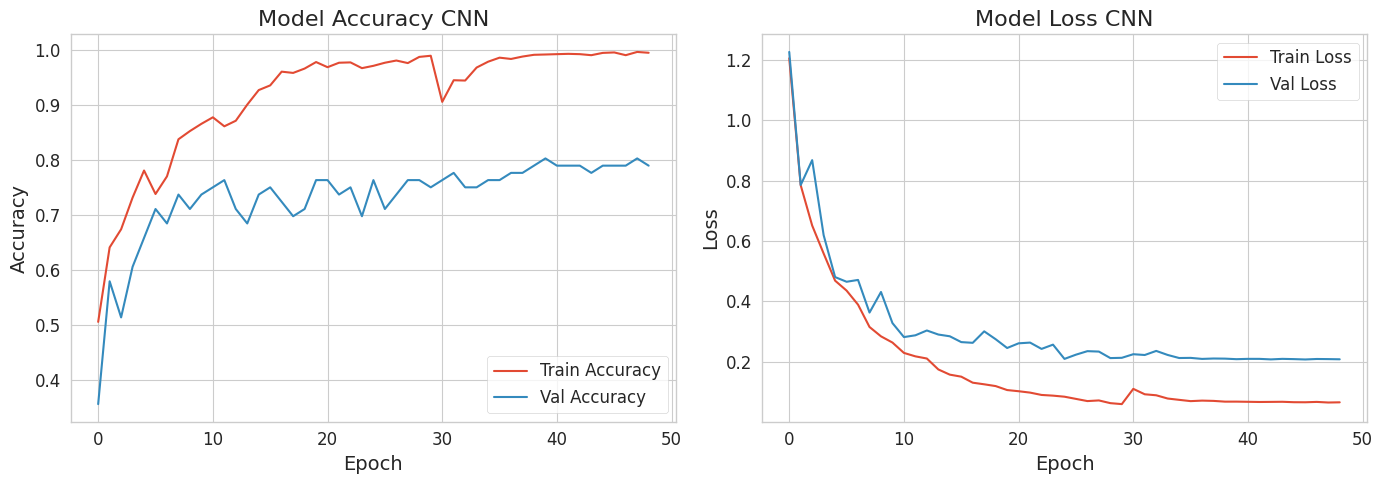


------------------------------------------------------------
CLASSIFICATION REPORT - CNN
------------------------------------------------------------
              precision    recall  f1-score   support

    Glaucoma     0.9524    1.0000    0.9756        20
      Myopia     0.6087    0.7000    0.6512        20
  Disc Edema     0.6842    0.6500    0.6667        20
     Healthy     0.8824    0.7500    0.8108        20

    accuracy                         0.7750        80
   macro avg     0.7819    0.7750    0.7761        80
weighted avg     0.7819    0.7750    0.7761        80


Overall Accuracy: 0.7750
Matthews Correlation Coefficient (MCC): 0.7015
Cohen's Kappa Score: 0.7000


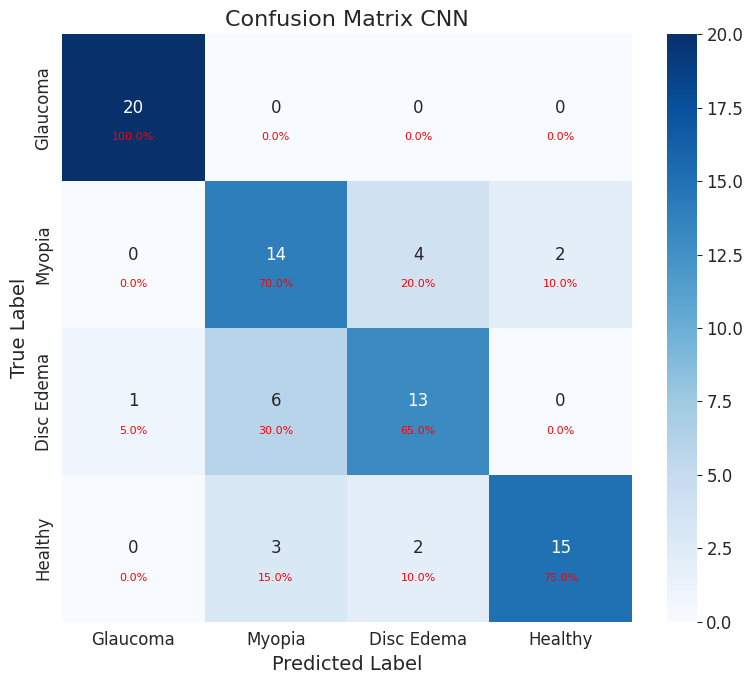

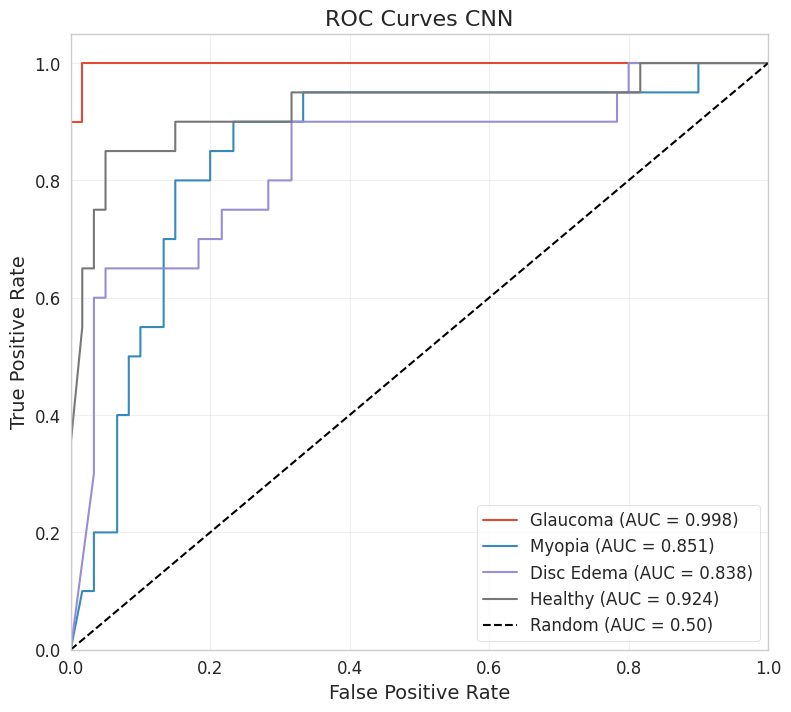

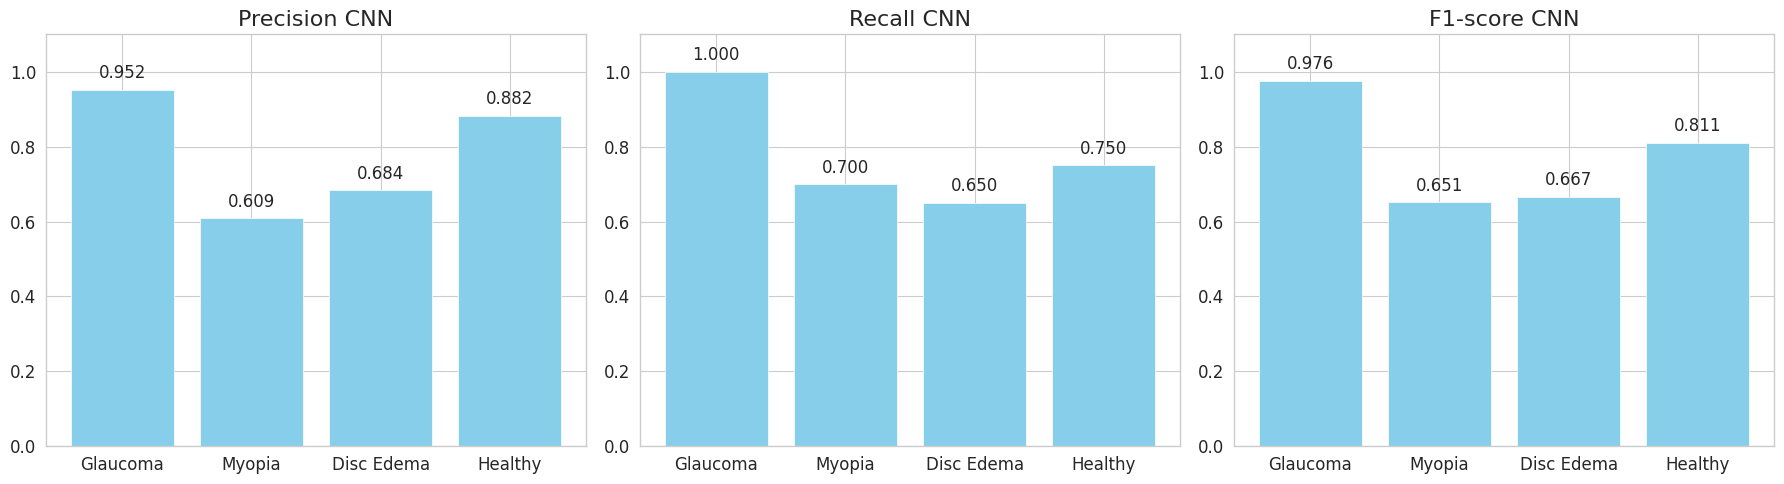

In [20]:
# Train CNN
cnn_probs, cnn_true = evaluate_cnn(cnn_model, test_ds, cnn_history, "CNN")

In [21]:
# Check if features already exist to avoid recomputation
try:
    train_features = np.load(MODEL_DIR / 'train_features.npy')
    train_labels = np.load(MODEL_DIR / 'train_labels.npy')
    val_features = np.load(MODEL_DIR / 'val_features.npy')
    val_labels = np.load(MODEL_DIR / 'val_labels.npy')
    print("Loaded pre-computed features")
except:
    print("Computing CNN features")
    train_features, train_labels = extract_cnn_features(cnn_model, train_ds)
    val_features, val_labels = extract_cnn_features(cnn_model, val_ds)

    # Save features to avoid recomputation
    np.save(MODEL_DIR / 'train_features.npy', train_features)
    np.save(MODEL_DIR / 'train_labels.npy', train_labels)
    np.save(MODEL_DIR / 'val_features.npy', val_features)
    np.save(MODEL_DIR / 'val_labels.npy', val_labels)

Computing CNN features

--- Extracting features from layer: 'concatenate' ---


Extracting features: 100%|██████████| 118/118 [00:28<00:00,  4.21it/s]



--- Extracting features from layer: 'concatenate' ---


Extracting features: 100%|██████████| 3/3 [00:01<00:00,  2.17it/s]


In [22]:
# Train XGBoost
xgb_model, best_params, xgb_scaler = train_xgboost_model(
    train_features, train_labels,
    val_features, val_labels
)

Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV] END colsample_bytree=0.7837667973909442, gamma=0.5216443460161492, learning_rate=0.014116655266337345, max_depth=7, min_child_weight=5, n_estimators=1202, reg_alpha=0.5194141088292848, reg_lambda=2.922137893158699, subsample=0.9656335998180612; total time= 9.5min
[CV] END colsample_bytree=0.8972025245281873, gamma=0.2041664879633806, learning_rate=0.010189323387612024, max_depth=11, min_child_weight=4, n_estimators=400, reg_alpha=0.12366695432774535, reg_lambda=1.358233078452774, subsample=0.6064564226510551; total time= 5.5min
[CV] END colsample_bytree=0.8972025245281873, ga

/usr/local/lib/python3.11/dist-packages/joblib/externals/loky/process_executor.py:782: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV] END colsample_bytree=0.7837667973909442, gamma=0.5216443460161492, learning_rate=0.014116655266337345, max_depth=7, min_child_weight=5, n_estimators=1202, reg_alpha=0.5194141088292848, reg_lambda=2.922137893158699, subsample=0.9656335998180612; total time= 9.5min
[CV] END colsample_bytree=0.7837667973909442, gamma=0.5216443460161492, learning_rate=0.014116655266337345, max_depth=7, min_child_weight=5, n_estimators=1202, reg_alpha=0.5194141088292848, reg_lambda=2.922137893158699, subsample=0.9656335998180612; total time= 4.9min
[CV] END colsample_bytree=0.8972025245281873, gamma=0.2041664879633806, learning_rate=0.010189323387612024, max_depth=11, min_child_weight=4, n_estimators=400, reg_alpha=0.12366695432774535, reg_lambda=1.358233078452774, subsample=0.6064564226510551; total time= 5.6min
[CV] END colsample_bytree=0.9482192930121008, gamma=0.7389739197131271, learning_rate=0.04108152701529922, max_depth=8, min_child_wei

In [23]:
# Extract features for XGBoost evaluation
X_test_features, y_test_xgb = extract_cnn_features(cnn_model, test_ds)


--- Extracting features from layer: 'concatenate' ---


Extracting features: 100%|██████████| 3/3 [00:01<00:00,  2.05it/s]


In [24]:
# Create ensemble
ensemble = CNNXGBoostEnsembleClassifier(cnn_model, xgb_model, xgb_scaler)

In [25]:
# Create ensemble classifier
ensemble = CNNXGBoostEnsembleClassifier(
    cnn_model,
    xgb_model,
    xgb_scaler,
    cnn_weight=ENSEMBLE_CNN_WEIGHT,
    xgb_weight=ENSEMBLE_XGB_WEIGHT
    )


--- Evaluating CNN Model ---


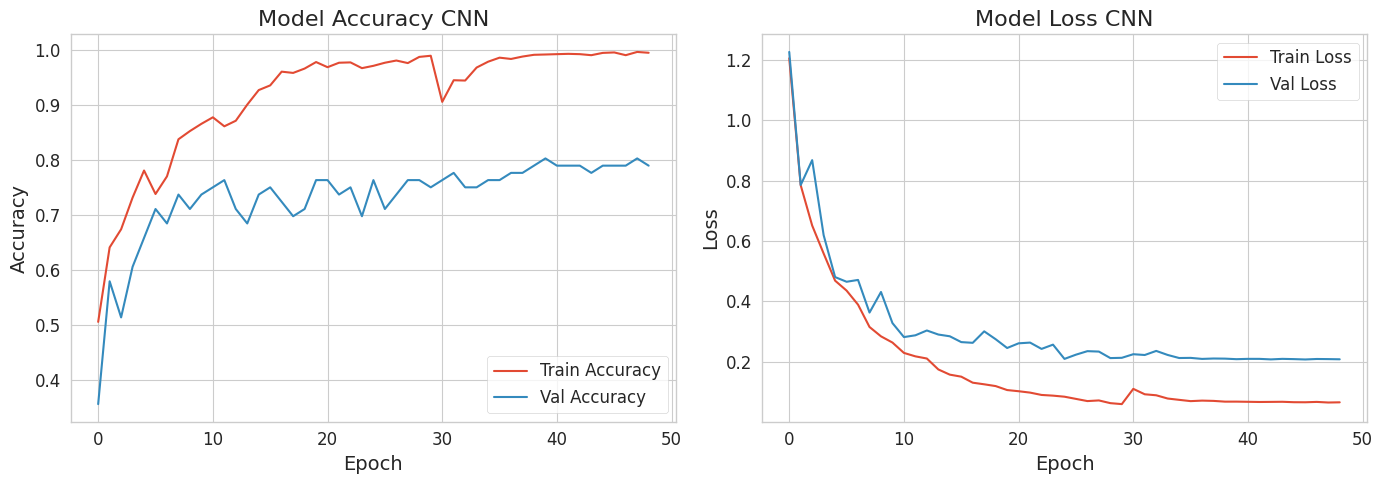


------------------------------------------------------------
CLASSIFICATION REPORT - CNN
------------------------------------------------------------
              precision    recall  f1-score   support

    Glaucoma     0.9524    1.0000    0.9756        20
      Myopia     0.6087    0.7000    0.6512        20
  Disc Edema     0.6842    0.6500    0.6667        20
     Healthy     0.8824    0.7500    0.8108        20

    accuracy                         0.7750        80
   macro avg     0.7819    0.7750    0.7761        80
weighted avg     0.7819    0.7750    0.7761        80


Overall Accuracy: 0.7750
Matthews Correlation Coefficient (MCC): 0.7015
Cohen's Kappa Score: 0.7000


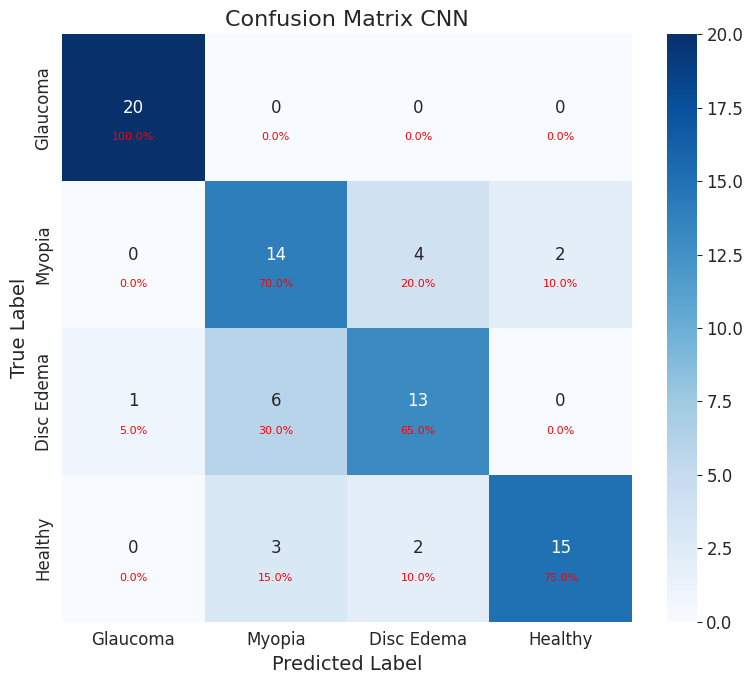

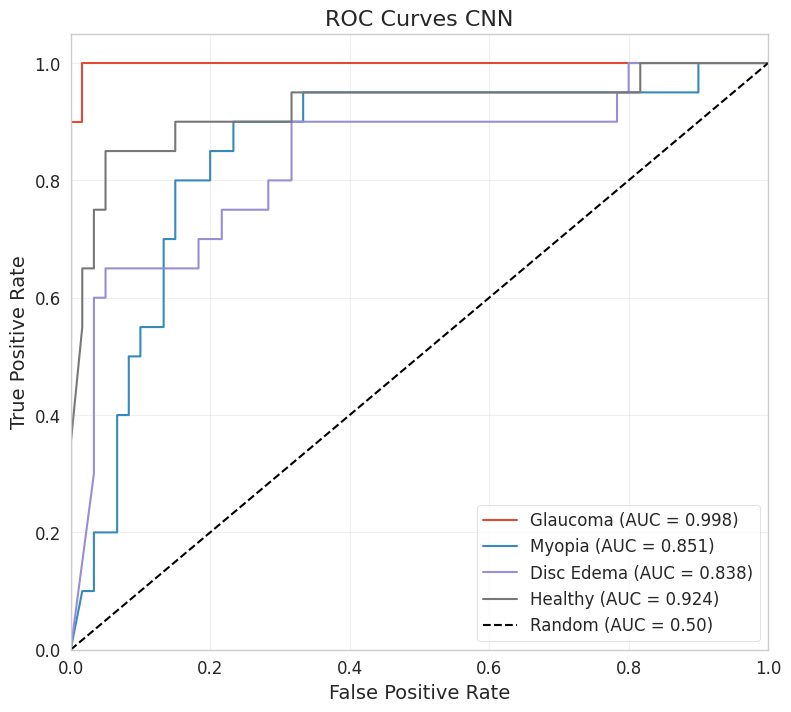

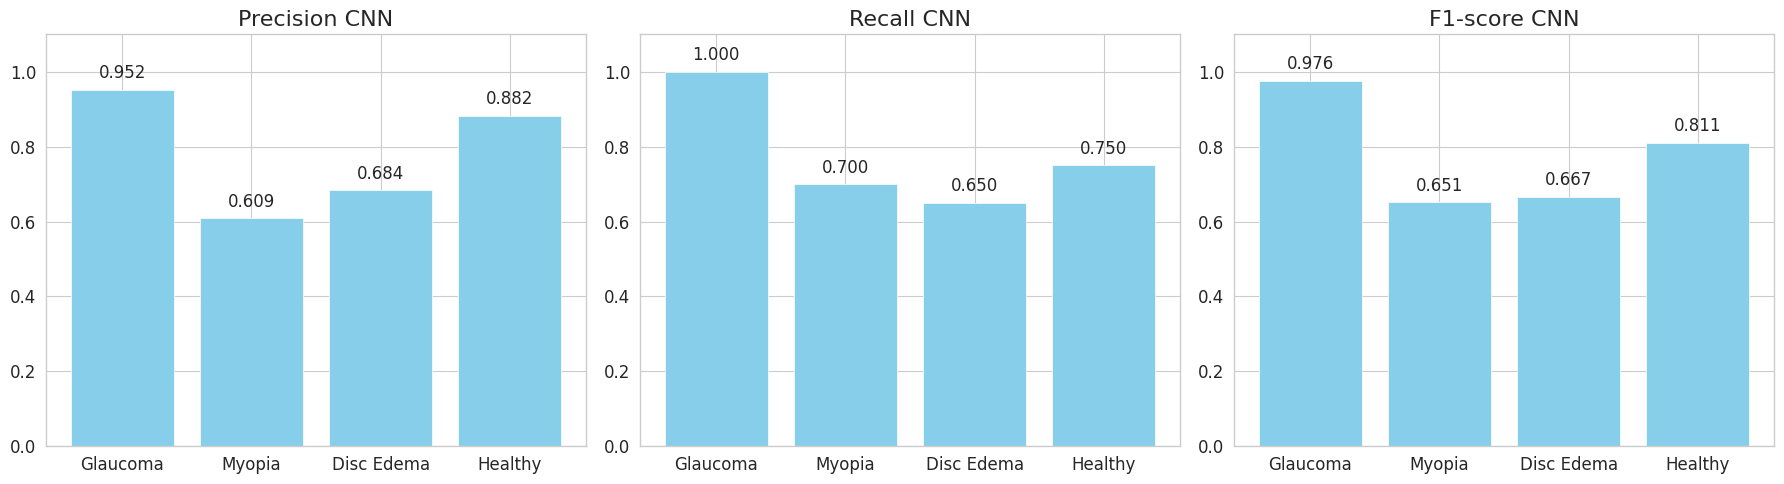


--- Evaluating XGBoost Model ---

------------------------------------------------------------
CLASSIFICATION REPORT - XGBOOST
------------------------------------------------------------
              precision    recall  f1-score   support

    Glaucoma     0.9524    1.0000    0.9756        20
      Myopia     0.6250    0.7500    0.6818        20
  Disc Edema     0.7222    0.6500    0.6842        20
     Healthy     0.8824    0.7500    0.8108        20

    accuracy                         0.7875        80
   macro avg     0.7955    0.7875    0.7881        80
weighted avg     0.7955    0.7875    0.7881        80


Overall Accuracy: 0.7875
Matthews Correlation Coefficient (MCC): 0.7189
Cohen's Kappa Score: 0.7167


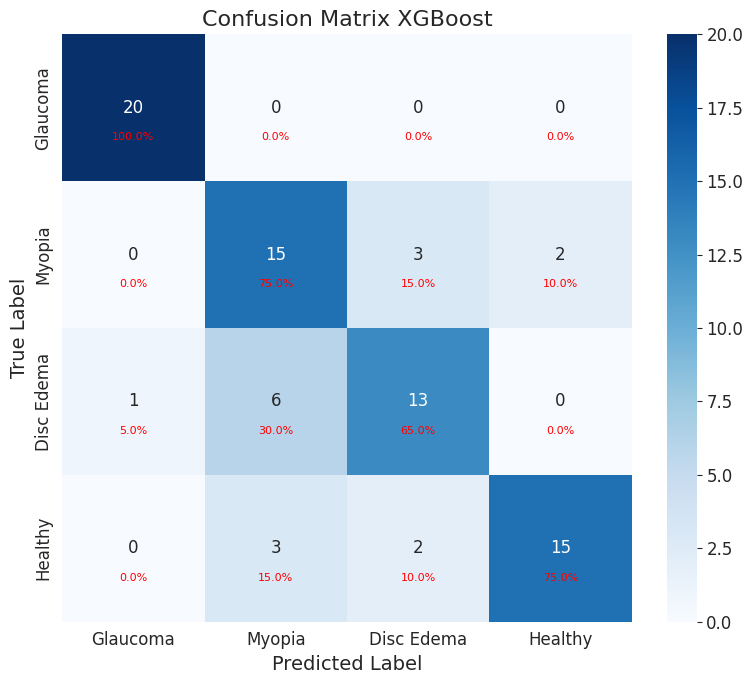

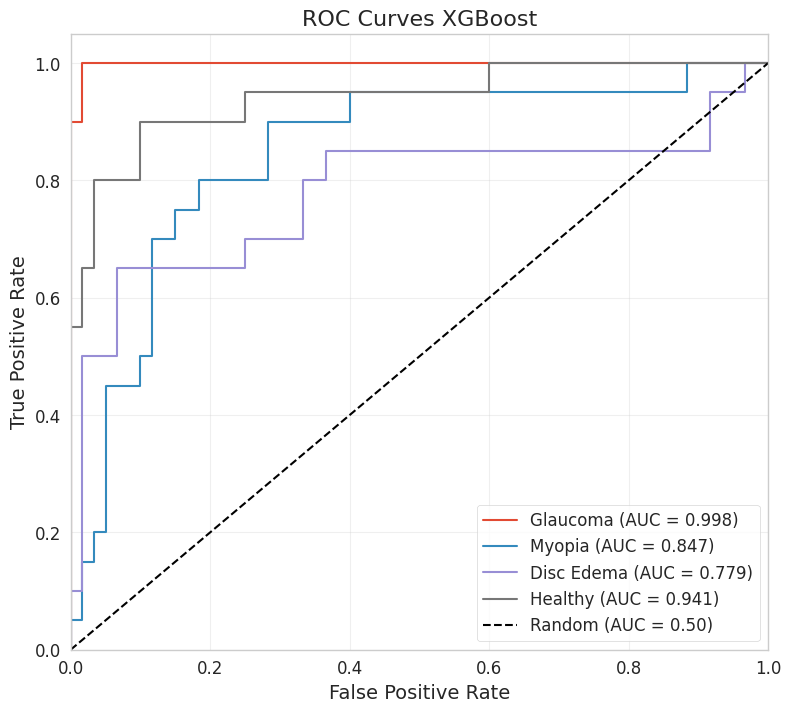

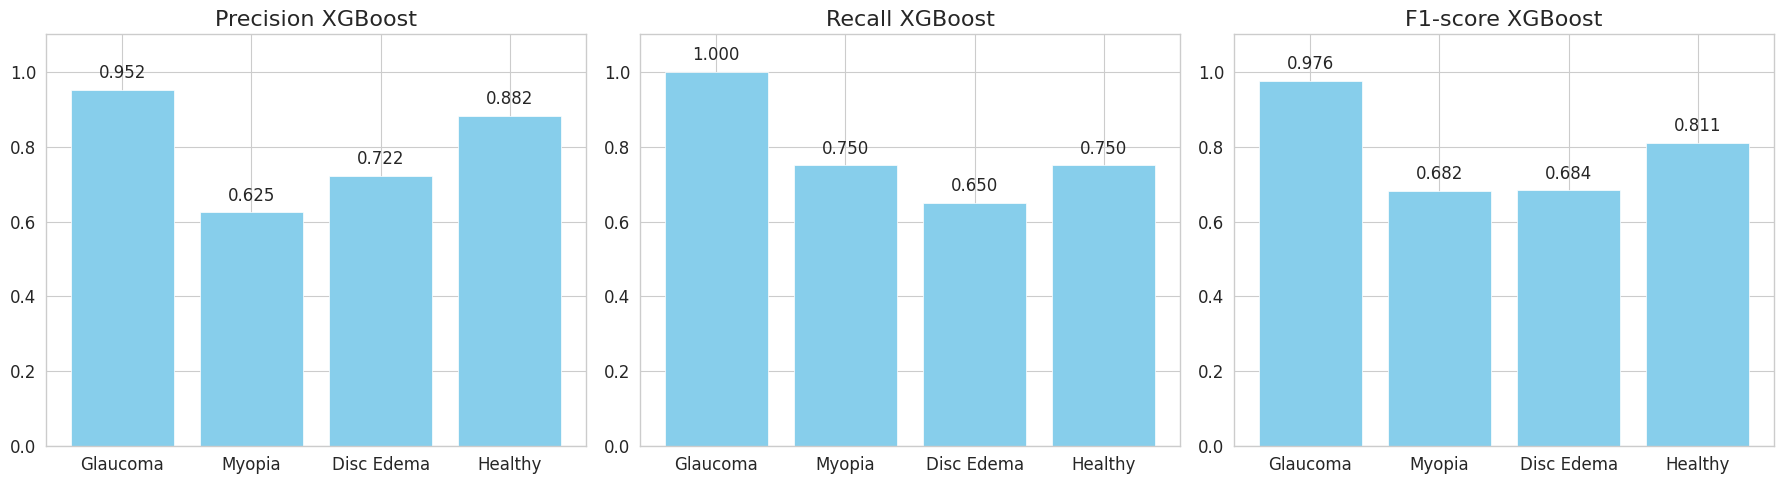

<Figure size 1200x800 with 0 Axes>

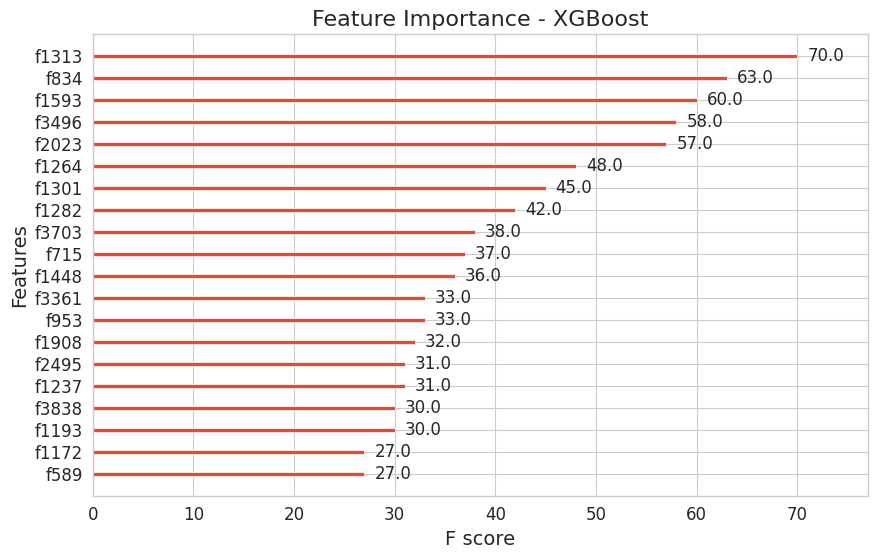


--- Evaluating Ensemble Model ---
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step

------------------------------------------------------------
CLASSIFICATION REPORT - ENSEMBLE
------------------------------------------------------------
              precision    recall  f1-score   support

    Glaucoma     0.9524    1.0000    0.9756        20
      Myopia     0.6250    0.7500    0.6818        20
  Disc Edema     0.7222    0.6500    0.6842        20
     Healthy     0.8824    0.7500    0.8108        20

    accuracy                         0.7875        80
   macro avg     0.7955    0.7875    0.7881        80
weighted avg     0.7955    0.7875    0.7881        80


Overall Accuracy: 0.7875
Matthews Correlation Coefficient (MCC): 0.7189
Cohen's Kappa Score: 0.7167


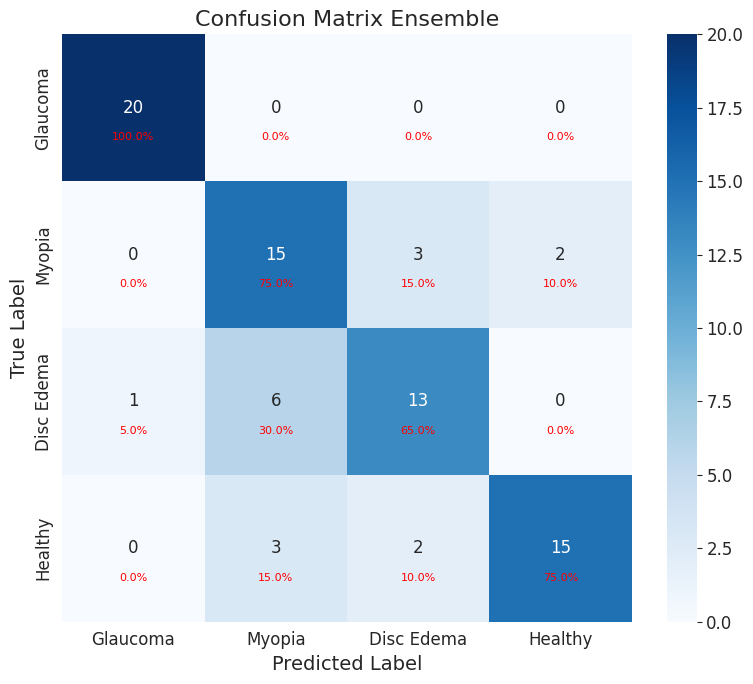

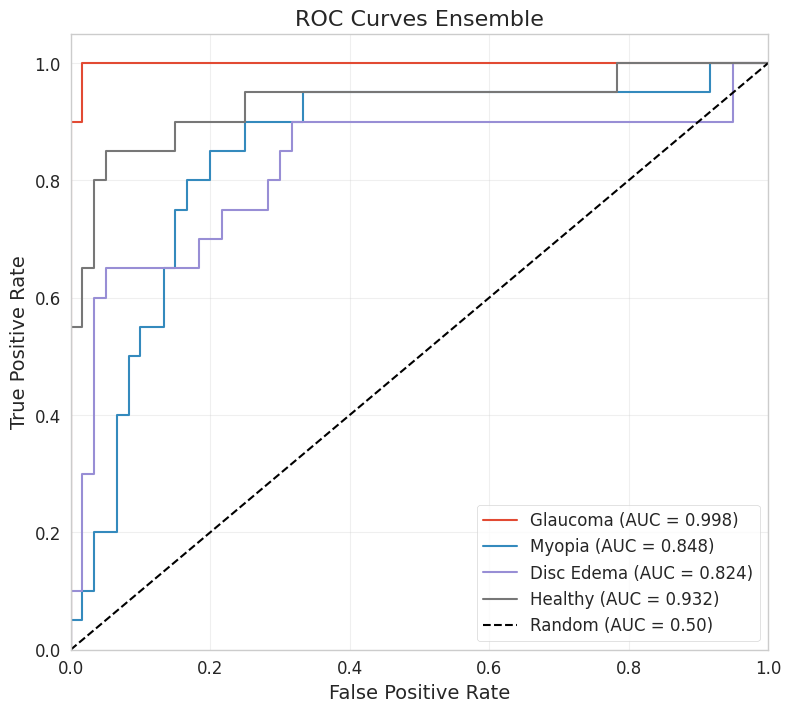

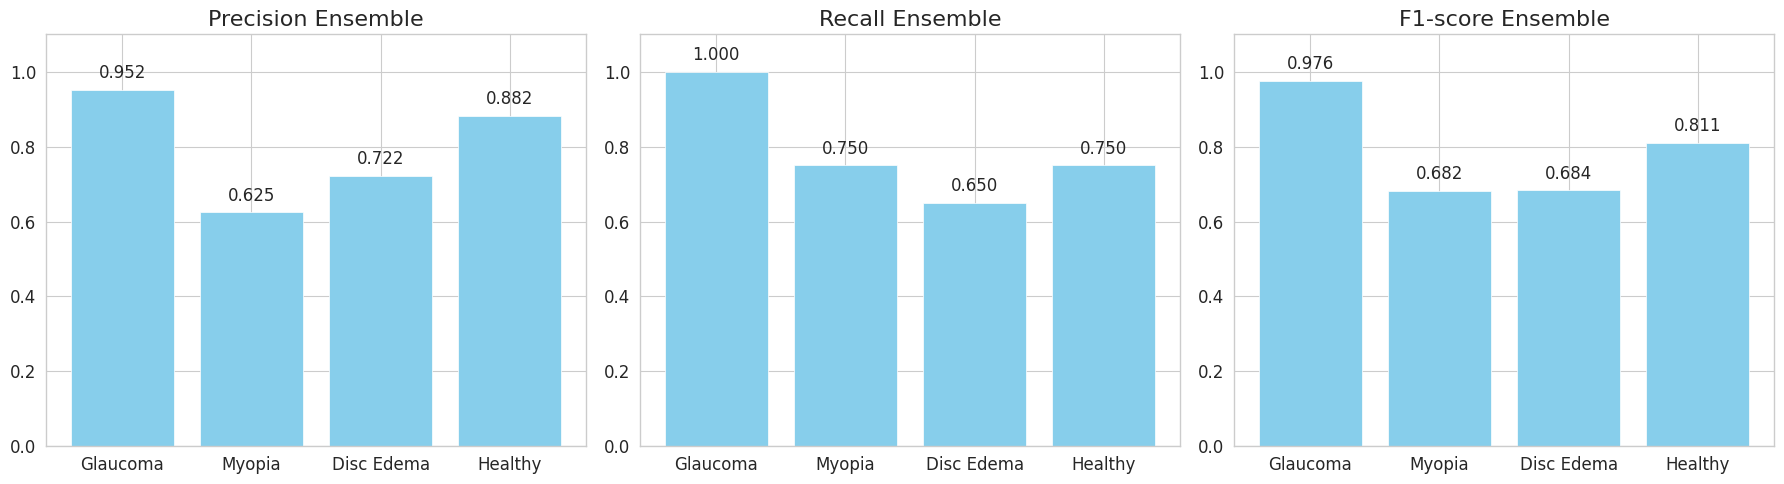


MODEL PERFORMANCE COMPARISON
      Model  Accuracy  Precision (Macro)  Recall (Macro)  F1-Score (Macro)
0       CNN    0.7750           0.781910          0.7750          0.776063
1   XGBoost    0.7875           0.795489          0.7875          0.788112
2  Ensemble    0.7875           0.795489          0.7875          0.788112


<Figure size 1200x600 with 0 Axes>

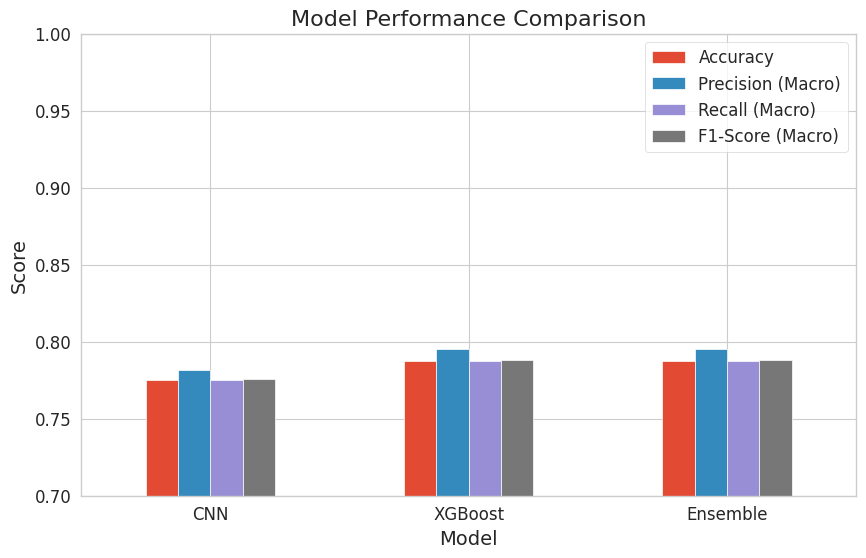

In [30]:
# Evaluate all models
comparison_df = evaluate_all_models(
    cnn_model,
    xgb_model,
    xgb_scaler,
    ensemble,
    test_ds,
    X_test_features,
    y_test_xgb
    )